# Training the model on images

## Imports

In [1]:
# load custom scripts
from dataset_images import Dataset
#from model import UNet

import config 

# import the necessary packages
from torch.nn import CrossEntropyLoss 
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from imutils import paths
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
import time
import os

## Setup CUDA

In [2]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"[INFO] CUDA version: {torch.version.cuda}")
  
# storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"[INFO] ID of current CUDA device:{torch.cuda.current_device()}")
        
print(f"[INFO] Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? True
[INFO] CUDA version: 11.1
[INFO] ID of current CUDA device:0
[INFO] Name of current CUDA device:NVIDIA GeForce RTX 3090


## Load images

In [3]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(config.MASK_DATASET_PATH)))

# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths, test_size=config.TEST_SPLIT, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(config.TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


## Create dataset

In [4]:
# create the train and test datasets
startTime = time.time()
trainDS = Dataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = Dataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set")
print(f"[INFO] found {len(testDS)} examples in the test set")
endTime = time.time()
print("[INFO] total time taken to load the data: {:.2f}s".format(endTime - startTime))

[INFO] found 2726 examples in the training set
[INFO] found 482 examples in the test set
[INFO] total time taken to load the data: 0.00s


In [5]:
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True, 
                         batch_size=config.BATCH_SIZE, 
                         pin_memory=config.PIN_MEMORY, 
                         num_workers=32,
                        persistent_workers=True)

testLoader = DataLoader(testDS, shuffle=False, 
                        batch_size=config.BATCH_SIZE, 
                        pin_memory=config.PIN_MEMORY, 
                        num_workers=32,
                       persistent_workers=True)

In [6]:
print(f"[INFO] batch_size:{config.BATCH_SIZE}")
print(f"[INFO] num_workers:{os.cpu_count()}")

[INFO] batch_size:64
[INFO] num_workers:32


## Examples

In [7]:
sample = trainDS[0]
print(f"Feature shape: {sample[0].shape}")
print(f"Labels shape: {sample[1].shape}")


Feature shape: torch.Size([3, 128, 128])
Labels shape: torch.Size([128, 128])


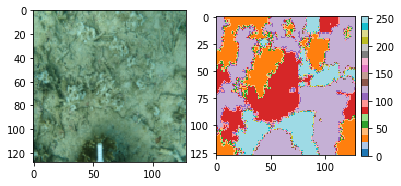

In [8]:
unnormalize = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                  transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ])])

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(unnormalize(sample[0]).permute(1, 2, 0))
im = ax[1].imshow(sample[1], cmap = "tab20", vmin=0, vmax=255)
fig.colorbar(im, fraction=0.046, pad=0.04)

## Model initialization

In [9]:
# import a pretrained model
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,      
    classes=256
)

In [10]:
#unet = UNet().to(config.DEVICE)
unet = model.to(config.DEVICE)

# initialize loss function
lossFunc = CrossEntropyLoss(ignore_index=255)

# initialize optimizer
opt = Adam(unet.parameters(), lr=config.INIT_LR)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // config.BATCH_SIZE
testSteps = len(testDS) // config.BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

## Training loop

[INFO] training the network...


  0%|                                                                                                                             | 0/40 [00:00<?, ?it/s]

whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever


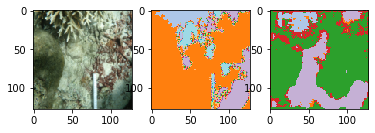

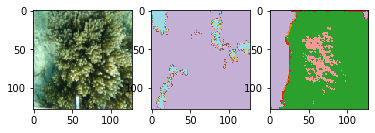

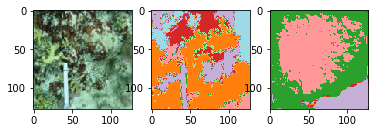

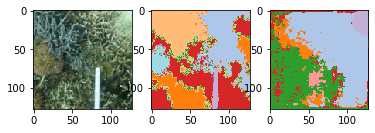

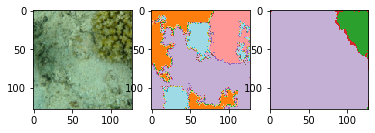

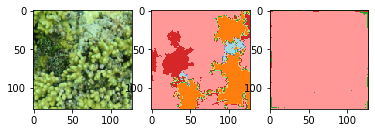

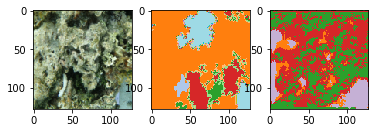

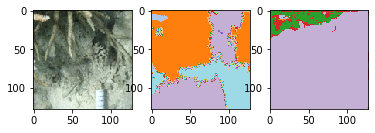

  2%|██▊                                                                                                               | 1/40 [01:44<1:07:51, 104.39s/it]

[INFO] EPOCH: 1/40
Train loss: 5.115139, Test loss: 5.0169


  2%|██▊                                                                                                               | 1/40 [02:29<1:37:28, 149.97s/it]


KeyboardInterrupt: 

In [11]:
# loop over epochs

unnormalize = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                  transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ])])

print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
    # set the model in training mode
    unet.train()

    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
        
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)
        
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        print("whatever")

        # add the loss to the total training loss so far
        totalTrainLoss += loss.item()
        
    
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        
        # loop over the validation set
        for (x, y) in testLoader:
            # send the input to the device
            (x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
            
            
            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y).item()
            
            fig, ax = plt.subplots(ncols=3)
            ax[0].imshow(unnormalize(x[0]).cpu().detach().permute(1, 2, 0))
            ax[1].imshow(y[0].cpu(), cmap = "tab20", vmin=0, vmax=255)
            ax[2].imshow(torch.argmax(pred[0],dim=0).cpu(), cmap = "tab20", vmin=0, vmax=255)
            plt.show()
            
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    
    # update our training history
    H["train_loss"].append(avgTrainLoss)
    H["test_loss"].append(avgTestLoss)
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
    
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

## Plotting the errors

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.ylim((0,20))
plt.legend(loc="upper right")
plt.savefig(config.PLOT_PATH)

# Save model

In [ ]:
# serialize the model to disk
torch.save(unet, config.MODEL_PATH)
print("[INFO] model saved !")